# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection

from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal
import set_rc_params as set_rc


%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']
reload(dt)
reload(set_rc)

# Global params
set_rc.set_rc_params()
root = pathlib.Path("/data")

BIN_SIZE = .03  # sec
WINDOW_prep = (-.4, .05)  # sec
WINDOW_exec = (-.05, .40)  # sec
n_components = 10  # min between M1 and PMd
areas = ('M1', 'PMd')

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )
fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_target_on', 
                                         rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                        )

%run dataset_selection.ipynb

the variable `GoodDataList` contains the session names


preprocessing

In [2]:
def plot_colored_line(ax, x, y, colors = None):
    """
    based on this:
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html?highlight=multicolored_line
    """
    if colors is None:
        colors = utility.get_colors(x.shape[0])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, colors=colors)

    lc.set_array(y)
    line = ax.add_collection(lc)
    ax.set_ylim([y.min(),y.max()])
    ax.set_xlim([x.min(),x.max()])
    
    return ax

def plot_3d_colored_line(ax, x, y, z, colors = None, **kwargs):
    """
    based on this:
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html?highlight=multicolored_line
    """
    from mpl_toolkits.mplot3d.art3d import Line3DCollection
    
    if colors is None:
        colors = utility.get_colors(x.shape[0])

    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = Line3DCollection(segments, colors=colors, **kwargs)

    lc.set_array(z)
    line = ax.add_collection(lc)
    ax.set_ylim([y.min(),y.max()])
    ax.set_xlim([x.min(),x.max()])
    ax.set_zlim([z.min(),z.max()])
    
    return ax

In [18]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

In [19]:
def prep_general (df):
    "preprocessing general!"
    time_signals = [signal for signal in pyal.get_time_varying_fields(df) if 'spikes' in signal]
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    for signal in time_signals:
        df_ = pyal.remove_low_firing_neurons(df, signal, 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in time_signals:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_

### Plot aligned trajectories

In [22]:
# Best M1 sessions
Bests_M1 = ('Chewie_CO_FF_2016-10-13.p', 'Jaco_CO_CS_2016-01-28.p')
BestDFs_M1 = []
for session in Bests_M1:
    path = root/session.split('_')[0]/session
    BestDFs_M1.append(prep_general(dt.load_pyal_data(path)))

ex_data = dt.get_data_array(BestDFs_M1, exec_epoch, area=areas[0], n_components=n_components)
n_time = ex_data.shape[-2]
n_trial = ex_data.shape[-3]

/home/msafaie/REPOS/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


Text(0.5, 0.98, 'Across monkey alignment')

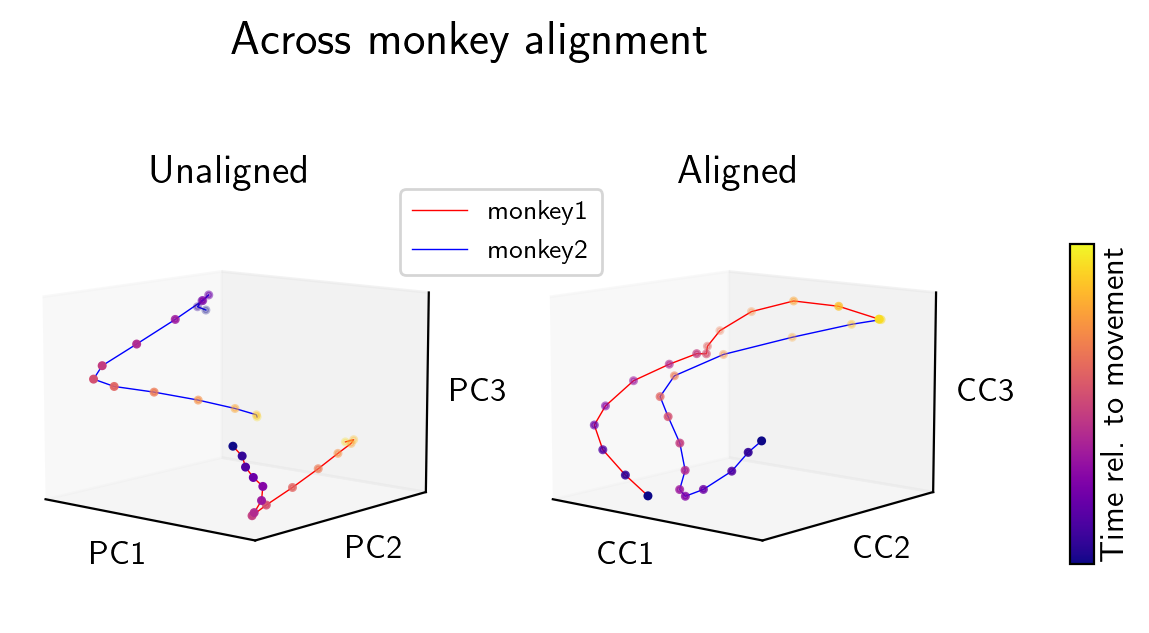

In [23]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,2,1, projection='3d',fc='None')
ax2 = fig.add_subplot(1,2,2, projection='3d',fc='None')
cax = fig.add_axes([1, 0.3, .02, 0.4])
axes = [ax,ax2]

target = 4
trial = 13

colors = utility.get_colors(n_time)
line_c=['r','b']
for i,ex in enumerate(ex_data):
    ax.scatter(ex[target,trial,:,0],ex[target,trial,:,1],ex[target,trial,:,2],
               c=colors, s=5)
    ax.plot(ex[target,trial,:,0],ex[target,trial,:,1],ex[target,trial,:,2],line_c[i],lw=.5)


data1 = np.reshape(ex_data[0,...], (-1,n_components))
data2 = np.reshape(ex_data[1,...], (-1,n_components))
*_,U,V = dt.canoncorr(data1, data2, fullReturn=True)
offset = (target*n_trial)*n_time + trial*n_time
ax2.scatter(U[offset:offset+n_time,0],U[offset:offset+n_time,1],U[offset:offset+n_time,2],
            c=colors, s=5)
l1=ax2.plot(U[offset:offset+n_time,0],U[offset:offset+n_time,1],U[offset:offset+n_time,2],
            line_c[0],lw=.5, label='monkey1')

ax2.scatter(V[offset:offset+n_time,0],V[offset:offset+n_time,1],V[offset:offset+n_time,2],
            c=colors, s=5)
l2=ax2.plot(V[offset:offset+n_time,0],V[offset:offset+n_time,1],V[offset:offset+n_time,2],
            line_c[1],lw=.5, label='monkey2')

titles=['Unaligned','Aligned']
labels = ['PC','CC']
for i, ax in enumerate(axes):
    ax.view_init(10,-50)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel(f'{labels[i]}1', labelpad=-10)
    ax.set_ylabel(f'{labels[i]}2', labelpad=-10)
    ax.set_zlabel(f'{labels[i]}3', labelpad=-10)
    ax.set_title(titles[i], pad=0)
axes[0].legend(handles=[l1[0], l2[0]],loc=(.9,.8))
fig.colorbar(cm.ScalarMappable(cmap='plasma'),cax=cax,ax=ax, label='Time rel. to movement', ticks=[])

fig.suptitle('Across monkey alignment', fontsize = 'xx-large')
